# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [14]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [15]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.413385
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Потому , что суммируется в знаменателе по десяти элементам, каждый элемент колеблется вокруг единицы, и в числителе один такой элемент*


In [16]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.144071 analytic: -2.144071, relative error: 5.685411e-09
numerical: -2.605971 analytic: -2.605971, relative error: 1.030905e-08
numerical: 4.451479 analytic: 4.451479, relative error: 3.709216e-09
numerical: 3.451371 analytic: 3.451371, relative error: 2.462136e-08
numerical: 0.189206 analytic: 0.189206, relative error: 1.972662e-07
numerical: 0.787074 analytic: 0.787074, relative error: 5.287779e-09
numerical: 3.971139 analytic: 3.971139, relative error: 1.739027e-08
numerical: -5.614336 analytic: -5.614336, relative error: 9.930122e-09
numerical: 1.162398 analytic: 1.162398, relative error: 4.623967e-08
numerical: 1.735740 analytic: 1.735740, relative error: 1.103260e-08
numerical: 1.021648 analytic: 1.022439, relative error: 3.869002e-04
numerical: -0.456456 analytic: -0.472140, relative error: 1.689017e-02
numerical: -0.072218 analytic: -0.064738, relative error: 5.461599e-02
numerical: -1.225014 analytic: -1.222357, relative error: 1.085495e-03
numerical: -0.980034 a

In [17]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.413385e+00 computed in 0.098423s
vectorized loss: 2.413385e+00 computed in 0.004409s
Loss difference: 0.000000
Gradient difference: 0.000000


In [19]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
range_lern_rate = np.linspace(learning_rates[0],learning_rates[1],10)
range_reg = np.linspace(regularization_strengths[0],regularization_strengths[1],10)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
for i in range_lern_rate:
    for j in range_reg:
        softmax = Softmax()
        tic = time.time()
        loss_hist = softmax.train(X_train, y_train, learning_rate=i, reg=j,num_iters=1500, verbose=True)
        toc = time.time()
        print('That took %fs' % (toc - tic))
        y_train_pred = softmax.predict(X_train)
        train_accur = np.mean(y_train == y_train_pred)   
        y_val_pred = softmax.predict(X_val)
        val_accur = np.mean(y_val == y_val_pred)
        results[(i, j)]=(train_accur, val_accur)
        
        if val_accur>best_val:
            best_val = val_accur
            best_softmax = softmax    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 392.911252
iteration 100 / 1500: loss 237.722584
iteration 200 / 1500: loss 144.621967
iteration 300 / 1500: loss 88.205732
iteration 400 / 1500: loss 54.070178
iteration 500 / 1500: loss 33.486344
iteration 600 / 1500: loss 21.071358
iteration 700 / 1500: loss 13.603166
iteration 800 / 1500: loss 8.978432
iteration 900 / 1500: loss 6.179748
iteration 1000 / 1500: loss 4.513044
iteration 1100 / 1500: loss 3.475400
iteration 1200 / 1500: loss 3.008592
iteration 1300 / 1500: loss 2.558985
iteration 1400 / 1500: loss 2.371883
That took 17.623913s
iteration 0 / 1500: loss 428.586523
iteration 100 / 1500: loss 245.399918
iteration 200 / 1500: loss 141.116425
iteration 300 / 1500: loss 81.534202
iteration 400 / 1500: loss 47.485530
iteration 500 / 1500: loss 28.002894
iteration 600 / 1500: loss 16.968556
iteration 700 / 1500: loss 10.496080
iteration 800 / 1500: loss 6.956401
iteration 900 / 1500: loss 4.868119
iteration 1000 / 1500: loss 3.650567
iteration 1100 / 15

iteration 500 / 1500: loss 4.960097
iteration 600 / 1500: loss 3.075999
iteration 700 / 1500: loss 2.451116
iteration 800 / 1500: loss 2.200932
iteration 900 / 1500: loss 2.146495
iteration 1000 / 1500: loss 2.032191
iteration 1100 / 1500: loss 2.066782
iteration 1200 / 1500: loss 2.055791
iteration 1300 / 1500: loss 1.949469
iteration 1400 / 1500: loss 2.062019
That took 17.766830s
iteration 0 / 1500: loss 605.367926
iteration 100 / 1500: loss 196.278284
iteration 200 / 1500: loss 64.716893
iteration 300 / 1500: loss 22.318762
iteration 400 / 1500: loss 8.658961
iteration 500 / 1500: loss 4.260769
iteration 600 / 1500: loss 2.701903
iteration 700 / 1500: loss 2.248914
iteration 800 / 1500: loss 2.148097
iteration 900 / 1500: loss 2.101291
iteration 1000 / 1500: loss 2.031444
iteration 1100 / 1500: loss 2.013360
iteration 1200 / 1500: loss 2.083216
iteration 1300 / 1500: loss 2.098141
iteration 1400 / 1500: loss 2.063387
That took 17.740958s
iteration 0 / 1500: loss 644.534281
iteratio

iteration 1100 / 1500: loss 2.022532
iteration 1200 / 1500: loss 2.055910
iteration 1300 / 1500: loss 2.118863
iteration 1400 / 1500: loss 2.106020
That took 17.423862s
iteration 0 / 1500: loss 772.946914
iteration 100 / 1500: loss 116.843589
iteration 200 / 1500: loss 19.191583
iteration 300 / 1500: loss 4.651046
iteration 400 / 1500: loss 2.484887
iteration 500 / 1500: loss 2.142160
iteration 600 / 1500: loss 2.078054
iteration 700 / 1500: loss 2.043982
iteration 800 / 1500: loss 2.065069
iteration 900 / 1500: loss 2.058414
iteration 1000 / 1500: loss 2.065668
iteration 1100 / 1500: loss 2.116362
iteration 1200 / 1500: loss 2.051560
iteration 1300 / 1500: loss 2.111298
iteration 1400 / 1500: loss 2.106965
That took 17.770364s
iteration 0 / 1500: loss 395.450298
iteration 100 / 1500: loss 122.675275
iteration 200 / 1500: loss 39.288047
iteration 300 / 1500: loss 13.540185
iteration 400 / 1500: loss 5.596484
iteration 500 / 1500: loss 3.146875
iteration 600 / 1500: loss 2.409617
iterat

iteration 200 / 1500: loss 14.384040
iteration 300 / 1500: loss 3.996710
iteration 400 / 1500: loss 2.346282
iteration 500 / 1500: loss 2.101132
iteration 600 / 1500: loss 2.083036
iteration 700 / 1500: loss 2.068241
iteration 800 / 1500: loss 2.040203
iteration 900 / 1500: loss 2.010004
iteration 1000 / 1500: loss 1.983601
iteration 1100 / 1500: loss 2.025666
iteration 1200 / 1500: loss 2.032896
iteration 1300 / 1500: loss 2.077109
iteration 1400 / 1500: loss 2.071358
That took 17.657768s
iteration 0 / 1500: loss 556.830219
iteration 100 / 1500: loss 75.043705
iteration 200 / 1500: loss 11.714847
iteration 300 / 1500: loss 3.319196
iteration 400 / 1500: loss 2.246104
iteration 500 / 1500: loss 2.077773
iteration 600 / 1500: loss 2.106828
iteration 700 / 1500: loss 2.028881
iteration 800 / 1500: loss 2.051328
iteration 900 / 1500: loss 2.027927
iteration 1000 / 1500: loss 2.053456
iteration 1100 / 1500: loss 2.064397
iteration 1200 / 1500: loss 2.031849
iteration 1300 / 1500: loss 2.10

iteration 900 / 1500: loss 2.068188
iteration 1000 / 1500: loss 2.105841
iteration 1100 / 1500: loss 2.066101
iteration 1200 / 1500: loss 2.088961
iteration 1300 / 1500: loss 2.051764
iteration 1400 / 1500: loss 2.046973
That took 18.013962s
iteration 0 / 1500: loss 740.693444
iteration 100 / 1500: loss 36.098473
iteration 200 / 1500: loss 3.682207
iteration 300 / 1500: loss 2.119058
iteration 400 / 1500: loss 2.082859
iteration 500 / 1500: loss 2.031579
iteration 600 / 1500: loss 2.100320
iteration 700 / 1500: loss 2.084345
iteration 800 / 1500: loss 2.091012
iteration 900 / 1500: loss 2.075582
iteration 1000 / 1500: loss 2.115357
iteration 1100 / 1500: loss 2.133858
iteration 1200 / 1500: loss 2.087499
iteration 1300 / 1500: loss 2.046360
iteration 1400 / 1500: loss 2.095285
That took 18.057697s
iteration 0 / 1500: loss 777.583531
iteration 100 / 1500: loss 31.973730
iteration 200 / 1500: loss 3.283654
iteration 300 / 1500: loss 2.132726
iteration 400 / 1500: loss 2.109461
iteration 

iteration 100 / 1500: loss 39.352417
iteration 200 / 1500: loss 4.980557
iteration 300 / 1500: loss 2.317362
iteration 400 / 1500: loss 2.047441
iteration 500 / 1500: loss 2.058840
iteration 600 / 1500: loss 2.085186
iteration 700 / 1500: loss 2.128061
iteration 800 / 1500: loss 2.057478
iteration 900 / 1500: loss 2.039407
iteration 1000 / 1500: loss 2.065891
iteration 1100 / 1500: loss 2.023885
iteration 1200 / 1500: loss 2.044405
iteration 1300 / 1500: loss 2.036888
iteration 1400 / 1500: loss 2.048355
That took 18.604017s
iteration 0 / 1500: loss 516.914311
iteration 100 / 1500: loss 34.202641
iteration 200 / 1500: loss 4.065895
iteration 300 / 1500: loss 2.194267
iteration 400 / 1500: loss 2.076590
iteration 500 / 1500: loss 2.055723
iteration 600 / 1500: loss 2.068726
iteration 700 / 1500: loss 1.972758
iteration 800 / 1500: loss 2.039454
iteration 900 / 1500: loss 2.013875
iteration 1000 / 1500: loss 2.087644
iteration 1100 / 1500: loss 2.017239
iteration 1200 / 1500: loss 2.0468

iteration 900 / 1500: loss 2.117952
iteration 1000 / 1500: loss 2.016959
iteration 1100 / 1500: loss 2.066049
iteration 1200 / 1500: loss 2.089392
iteration 1300 / 1500: loss 2.085707
iteration 1400 / 1500: loss 2.086533
That took 18.037640s
iteration 0 / 1500: loss 693.340641
iteration 100 / 1500: loss 13.476382
iteration 200 / 1500: loss 2.296164
iteration 300 / 1500: loss 2.105364
iteration 400 / 1500: loss 2.075054
iteration 500 / 1500: loss 2.064733
iteration 600 / 1500: loss 2.075871
iteration 700 / 1500: loss 2.130510
iteration 800 / 1500: loss 2.075296
iteration 900 / 1500: loss 2.055450
iteration 1000 / 1500: loss 2.107999
iteration 1100 / 1500: loss 2.140820
iteration 1200 / 1500: loss 2.080864
iteration 1300 / 1500: loss 2.089211
iteration 1400 / 1500: loss 2.089307
That took 17.981228s
iteration 0 / 1500: loss 734.309732
iteration 100 / 1500: loss 11.464299
iteration 200 / 1500: loss 2.230642
iteration 300 / 1500: loss 2.134540
iteration 400 / 1500: loss 2.113691
iteration 

In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.346000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:Да

*Your explanation*:В SVM если добавить точку, score которой будет за пределами margin от правильного класса, она никак не повлияет на loss, однако в SVM даже точка, очень сильно удалённая по score от правильного класса, повлияет на loss.

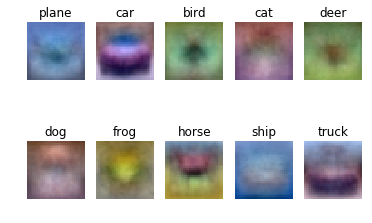

In [12]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])